In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/NN_proj/OCT2017_dataset.zip' &> /dev/null

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from collections import defaultdict
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import glob
from itertools import repeat
from itertools import product

from keras.layers import Input, Multiply,GlobalAveragePooling2D, Add, Dense, Activation, Maximum, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Lambda, UpSampling2D, DepthwiseConv2D, SeparableConv2D
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization, ReLU
from keras.applications.vgg16 import VGG16
from keras.models import Model

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input


import matplotlib.cm as cm
from IPython.display import Image, display

import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter

In [ ]:
# Data path
TRAIN_PATH = r'/content/OCT2017/train/'
VAL_PATH = r'/content/OCT2017/val/'
TEST_PATH = r'/content/OCT2017/test/'

# Parameters
CLASSES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
NUM_CLASSES = len(CLASSES)
IMG_DIMS = 128
IMG_SHAPE = (IMG_DIMS, IMG_DIMS, 3)

BATCH_SIZE = 64

The size of  df_train_CNV  is (37205, 2) 
The size of  df_train_DME  is (11348, 2) 
The size of  df_train_DRUSEN  is (8616, 2) 
The size of  df_train_NORMAL  is (26315, 2) 


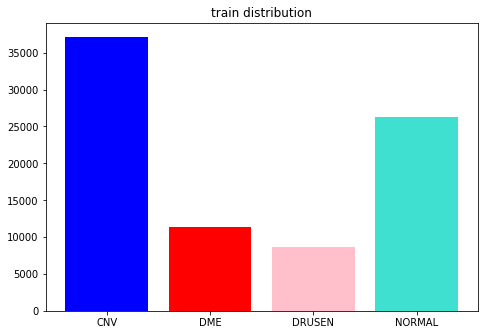

The size of  df_val_CNV  is (8, 2) 
The size of  df_val_DME  is (8, 2) 
The size of  df_val_DRUSEN  is (8, 2) 
The size of  df_val_NORMAL  is (8, 2) 


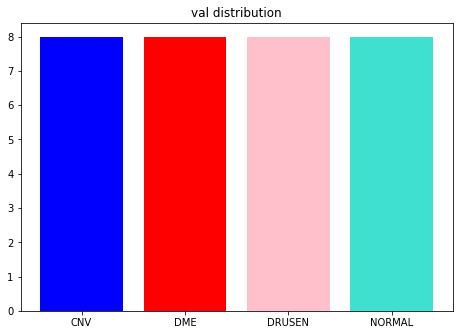

The size of  df_test_CNV  is (242, 2) 
The size of  df_test_DME  is (242, 2) 
The size of  df_test_DRUSEN  is (242, 2) 
The size of  df_test_NORMAL  is (242, 2) 


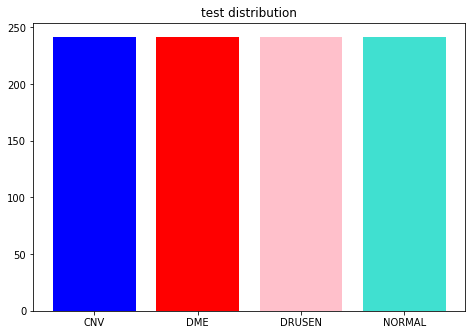

In [ ]:
# load data, plot class distribution

def load_data(path, label, class_type):
    
    image_list = glob.glob(path + class_type + '/*')
    label_list = list(repeat(label, len(image_list)))
    
    data = list(zip(image_list,label_list))
    df = pd.DataFrame(data, columns = ['images', 'labels'])

    return df
        

def plot_dataset_imbalance(sample_distribution, title): 
    colors = ['blue', 'red', 'pink', 'turquoise']
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(CLASSES, sample_distribution, color=colors)
    plt.title(title + ' distribution')
    plt.show()
        
        
        
for dataset, path in list(zip(['train', 'val', 'test'], [TRAIN_PATH, VAL_PATH, TEST_PATH])):
  
    for label,class_type in enumerate(CLASSES):
        df_var = "df_" + dataset + "_" + class_type
        vars()[df_var] = load_data(path, str(label), class_type)
        sample_size_var = "num_" + class_type
        vars()[sample_size_var] = vars()[df_var].shape[0]        
        print('The size of ', df_var, ' is {} '.format(vars()[df_var].shape))
    
    sample_distribution = [num_CNV, num_DME, num_DRUSEN, num_NORMAL]
    plot_dataset_imbalance(sample_distribution, dataset)

In [ ]:
def get_train_set():
    df_train_upsample = pd.concat([df_train_CNV, 
                            df_train_DME,
                            df_train_DRUSEN,
                            df_train_NORMAL], axis=0).reset_index(drop=True)


    df_train = shuffle(df_train_upsample)
    print('The size of df_train is {}'.format(df_train.shape))
      
    return df_train

df_train = get_train_set()

The size of df_train is (83484, 2)


In [ ]:
def get_val_set():

    df_val_upsample = pd.concat([df_val_CNV, df_val_CNV,
                            df_val_DME, df_val_DME,
                            df_val_DRUSEN, df_val_DRUSEN,
                            df_val_NORMAL, df_val_NORMAL], axis=0).reset_index(drop=True)

    df_val = shuffle(df_val_upsample)
    print('The size of df_val is {}'.format(df_val.shape))
      
    return df_val

df_val = get_val_set()

The size of df_val is (64, 2)


In [ ]:
def get_test_set():
    
    df_test_combined = pd.concat([df_test_CNV,  
                                  df_test_DME,  
                                  df_test_DRUSEN, 
                                  df_test_NORMAL], 
                                 axis=0).reset_index(drop=True)
    df_test = shuffle(df_test_combined)
    print('The size of df_test is {}'.format(df_test.shape))

    return df_test

df_test = get_test_set()

The size of df_test is (968, 2)


In [ ]:
def get_class_weights(verbose=1):
    
    counter = Counter(df_train.labels)                          
    max_count = float(max(counter.values()))  
    class_weights = {int(class_label) : max_count/num_images for class_label, 
                     num_images in counter.items()}                     
    if verbose:
        print('Class weights: \n', class_weights)
    return class_weights

In [ ]:
def get_train_data(augmentation=0):
    
    if augmentation:
        train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    fill_mode='nearest',
                                    zoom_range = 0.3,
                                    horizontal_flip = True)        
    else:    
        train_datagen = ImageDataGenerator(rescale=1./255)
        
    
    train_data= train_datagen.flow_from_dataframe(dataframe=df_train, 
                                            #directory=TRAIN_IMG_DIR, 
                                            directory=None,    # paths specified in x_col
                                            x_col="images", 
                                            y_col="labels", 
                                            class_mode="categorical",  # for multiclass
                                            target_size=(IMG_DIMS, IMG_DIMS),
                                            batch_size=BATCH_SIZE)
    return train_data

def get_valid_data():
    
    valid_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    fill_mode='nearest',
                                    zoom_range = 0.3,
                                    horizontal_flip = True)
    valid_data = valid_datagen.flow_from_dataframe(dataframe=df_val, 
                                             directory=None, 
                                             x_col="images", 
                                             y_col="labels", 
                                             class_mode="categorical",
                                             shuffle= True,
                                             target_size=(IMG_DIMS, IMG_DIMS),
                                             batch_size=BATCH_SIZE)
    return valid_data

def get_test_data():
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_data = test_datagen.flow_from_dataframe(dataframe=df_test, 
                                             directory=None, 
                                             x_col="images", 
                                             y_col="labels", 
                                             class_mode="categorical",
                                             shuffle= False,
                                             target_size=(IMG_DIMS, IMG_DIMS),
                                             batch_size=BATCH_SIZE)
    return test_data

In [ ]:
train_data = get_train_data(augmentation=0)

val_data = get_valid_data()

test_data = get_test_data()

class_weights = get_class_weights()

Found 83484 validated image filenames belonging to 4 classes.
Found 64 validated image filenames belonging to 4 classes.
Found 968 validated image filenames belonging to 4 classes.
Class weights: 
 {0: 1.0, 3: 1.4138324149724493, 2: 4.3181290622098425, 1: 3.2785512865703206}


In [ ]:
def res_conv(X, filters, base, s):
    
    name_base = base + '/branch'
    
    F1, F2, F3 = filters

    ##### Branch1 is the main path and Branch2 is the shortcut path #####
    
    X_shortcut = X
    
    ##### Branch1 #####
    # First component of Branch1 
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_1')(X)
    X= Activation('relu', name=name_base + '1/relu_1')(X)
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_1', kernel_initializer=glorot_uniform(seed=0))(X)

    # Second component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_2')(X)
    X = Activation('relu', name=name_base + '1/relu_2')(X)
    X = Conv2D(filters=F2, kernel_size=(2,2), strides=(s,s), padding='same', name=name_base + '1/conv_2', kernel_initializer=glorot_uniform(seed=0))(X)
    
    # Third component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_3')(X)
    X = Activation('relu', name=name_base + '1/relu_3')(X)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_3', kernel_initializer=glorot_uniform(seed=0))(X)
    
    ##### Branch2 ####
    X_shortcut = BatchNormalization(axis=-1, name=name_base + '2/bn_1')(X_shortcut)
    X_shortcut= Activation('relu', name=name_base + '2/relu_1')(X_shortcut)
    X_shortcut = Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', name=name_base + '2/conv_1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    
    # Final step: Add Branch1 and Branch2
    X = Add(name=base + '/Add')([X, X_shortcut])

    return X

def res_identity(X, filters, base):
    
    name_base = base + '/branch'
    
    F1, F2, F3 = filters

    ##### Branch1 is the main path and Branch2 is the shortcut path #####
    
    X_shortcut = X
    
    ##### Branch1 #####
    # First component of Branch1 
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_1')(X)
    Shortcut= Activation('relu', name=name_base + '1/relu_1')(X)
    X = Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_1', kernel_initializer=glorot_uniform(seed=0))(Shortcut)

    # Second component BranchOut 1
    X1 = BatchNormalization(axis=-1, name=name_base + '1/ConvBn_2')(X)
    X1 = Activation('relu', name=name_base + '1/ConvRelu_2')(X1)
    X1 = Conv2D(filters=F2, kernel_size=(2,2), dilation_rate=(2, 2),strides=(1,1), padding='same', name=name_base + '1/Conv_2', kernel_initializer=glorot_uniform(seed=0))(X1)
    
    # Second component BrancOut 2
    X2 = BatchNormalization(axis=-1, name=name_base + '1/SepBn_2')(X)
    X2 = Activation('relu', name=name_base + '1/SepRelu_2')(X2)
    X2 = SeparableConv2D(filters=F2, kernel_size=(2,2), dilation_rate=(2, 2),strides=(1,1), padding='same', name=name_base + '1/SepConv_2', kernel_initializer=glorot_uniform(seed=0))(X2)
    
    # Second component Add-BranchOut
    X = Add(name=base + '/Add-2branches')([X1, X2])
    
    # Third component of Branch1
    X = BatchNormalization(axis=-1, name=name_base + '1/bn_3')(X)
    X = Activation('relu', name=name_base + '1/relu_3')(X)
    X = Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', name=name_base + '1/conv_3', kernel_initializer=glorot_uniform(seed=0))(X)    
    
    # Final step: Add Branch1 and the original Input itself
    X = Add(name=base + '/Add')([X_shortcut,X])

    return X

def EncoderDecoder(X, name_base):
    X = MaxPooling2D((3,3), strides=(2,2), padding='same', name = name_base + '/Downsample1')(X)
    #X = Conv2D(outgoing_depth, (2,2), strides=(1,1), dilation_rate=(2,2), padding='same', name = name_base + '/DC1', kernel_initializer=glorot_uniform(seed=0))(X)    
    X = UpSampling2D(size=(2, 2),interpolation='bilinear',name = name_base + '/Upsample1')(X)
    X = Activation('sigmoid', name = name_base + '/Activate')(X)
    return X

def RDBI(X, filters, base, number):
    
    for i in range(number):
        X = res_identity(X, filters, base+ '/id_'+str(1+i))
    
    return X
def OpticNet(input_size,num_of_classes):
    input_shape=(input_size, input_size, 3) # Height x Width x Channel
    X_input = Input(input_shape)
    X = Conv2D(64, (7,7), strides=(2,2), padding='same', name ='CONV1', kernel_initializer=glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis=-1, name ='BN1')(X)
    X = Activation('relu', name ='RELU1')(X)
    X = res_conv(X, [64,64,256], 'RC0', 1)
    
    # MID 1
    X1 = EncoderDecoder(X, 'EncoderDecoder1')
    X2 = RDBI(X, [32,32,256], 'RDBI1',4)
    X = Multiply(name = 'Mutiply1')([X1,X2])
    X = Add(name = 'Add1')([X,X1,X2])
    X = res_conv(X, [128,128,512], 'RC1', 2)
    
    # MID 2
    X1 = EncoderDecoder(X, 'EncoderDecoder2')
    X2 = RDBI(X, [64,64,512], 'RDBI2',4)
    X = Multiply(name = 'Mutiply2')([X1,X2])
    X = Add(name = 'Add2')([X,X1,X2])
    X = res_conv(X, [256,256,1024], 'RC2', 2)
    
    # MID 3
    X1 = EncoderDecoder(X, 'EncoderDecoder3')
    X2 = RDBI(X, [128,128,1024], 'RDBI3',3)
    X = Multiply(name = 'Mutiply3')([X1,X2])
    X = Add(name = 'Add3')([X,X1,X2])
    X = res_conv(X, [512,512,2048], 'RC3', 2)
    
    # MID 4
    X1 = EncoderDecoder(X, 'EncoderDecoder4')
    X2 = RDBI(X, [256,256,2048], 'RDBI4',3)
    X = Multiply(name = 'Mutiply4')([X1,X2])
    X = Add(name = 'Add4')([X,X1,X2]) 
    
    X = GlobalAveragePooling2D(name='global_avg_pool')(X)
    X = Dense(256, name='Dense_1')(X)
    X = Dense(num_of_classes, name='Dense_2')(X)
    X = Activation('softmax', name='classifier')(X)
    
    model = Model(inputs=X_input, outputs=X, name='')

    return model

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
def plot_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
# It prints & plots the confusion matrix, normalization can be applied by setting normalize=True.
    
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc_curves(y_true, y_pred, num_classes, class_labels):
    
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_test = lb.transform(y_true)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    for i in range(num_classes):
        fig, c_ax = plt.subplots(1,1, figsize = (6, 4))
        c_ax.plot(fpr[i], tpr[i],
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_labels[i], roc_auc[i]))
        c_ax.set_xlabel('False Positive Rate')
        c_ax.set_ylabel('True Positive Rate')
        c_ax.set_title('ROC curve of class {0}'.format(class_labels[i]))
        c_ax.legend(loc="lower right")
        plt.show()
    return roc_auc_score(y_test, y_pred)

def evaluate_model(model, history, test_generator):
    # Evaluate model
    score = model.evaluate(test_generator, verbose=0)
    print('\nTest set accuracy:', score[1], '\n')
    
    y_true = np.array(test_generator.labels)
    y_pred = model.predict(test_generator, verbose = 1)
    y_pred_classes = np.argmax(y_pred,axis = 1)
    class_labels = list(test_generator.class_indices.keys())   
    
    print('\n', sklearn.metrics.classification_report(y_true, y_pred_classes, target_names=class_labels), sep='')
    confusion_mtx = confusion_matrix(y_true, y_pred_classes)
    plot_acc(history)
    plt.show()
    plot_loss(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = class_labels)
    plt.show()
    print("ROS AUC score:", plot_roc_curves(y_true, y_pred,3, class_labels))

In [ ]:
def train_model(model, train_generator, test_generator, num_epochs, optimizer, class_weights):
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=1, min_lr=1e-8, mode='auto')
    checkpoint = tf.keras.callbacks.ModelCheckpoint('OpticNet_best.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto', save_weights_only=False, save_freq='epoch')
    # Train using .fit
    history = model.fit(train_generator,
                        epochs=num_epochs, 
                        validation_data=test_generator,
                        class_weight = class_weights, 
                        steps_per_epoch=train_generator.samples // BATCH_SIZE, 
                        validation_steps=test_generator.samples // BATCH_SIZE,
                        verbose=1,
                        callbacks = [early_stop, rlr, checkpoint])
    
    return model, history

In [ ]:
opticnet_model = OpticNet(IMG_DIMS, NUM_CLASSES)
opticnet_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 CONV1 (Conv2D)                 (None, 64, 64, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 BN1 (BatchNormalization)       (None, 64, 64, 64)   256         ['CONV1[0][0]']                  
                                                                                                  
 RELU1 (Activation)             (None, 64, 64, 64)   0           ['BN1[0][0]']              

In [ ]:
opticnet_model, opticnet_history = train_model(opticnet_model, train_data, test_data, 10, Adam(learning_rate=1e-4), None)

Epoch 1/10
1304/1304 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.7717
Epoch 1: val_loss improved from inf to 0.72305, saving model to OpticNet_best.h5
1304/1304 [==============================] - 1499s 1s/step - loss: 0.6523 - accuracy: 0.7717 - val_loss: 0.7230 - val_accuracy: 0.7365 - lr: 1.0000e-04
Epoch 2/10
1304/1304 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.9012
Epoch 2: val_loss improved from 0.72305 to 0.23398, saving model to OpticNet_best.h5
1304/1304 [==============================] - 1478s 1s/step - loss: 0.2882 - accuracy: 0.9012 - val_loss: 0.2340 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 3/10
1304/1304 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9263
Epoch 3: val_loss improved from 0.23398 to 0.17820, saving model to OpticNet_best.h5
1304/1304 [==============================] - 1474s 1s/step - loss: 0.2128 - accuracy: 0.9263 - val_loss: 0.1782 - val_accuracy: 0.9302 - lr: 1.0000e-04


Test set accuracy: 0.9886363744735718 

16/16 [==============================] - 6s 310ms/step

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       242
           1       0.98      0.99      0.99       242
           2       0.98      1.00      0.99       242
           3       1.00      0.99      0.99       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968



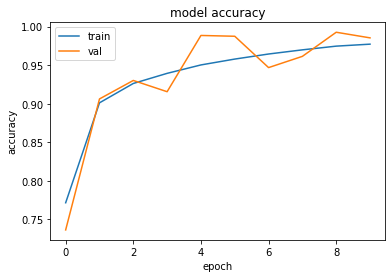

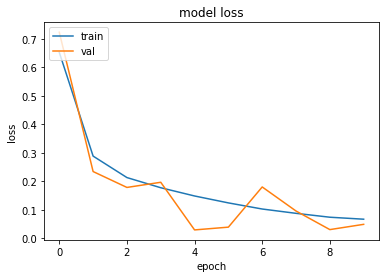

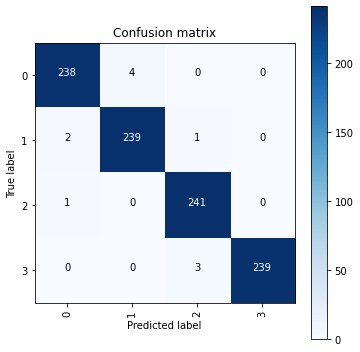

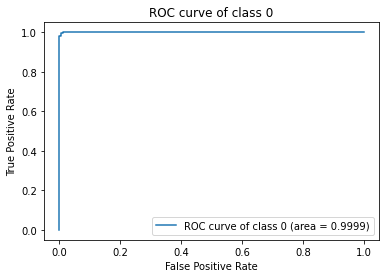

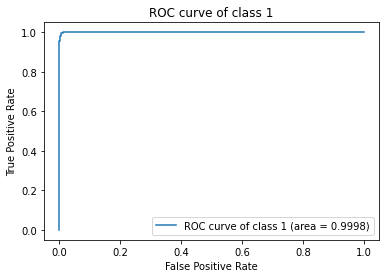

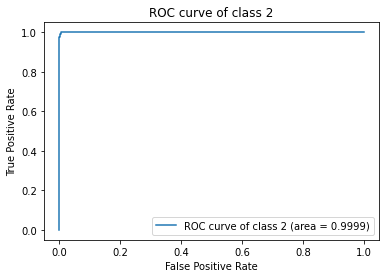

ROS AUC score: 0.9998961250369965


In [ ]:
from keras.models import load_model
best_model = load_model('/content/OpticNet_best.h5')

evaluate_model(best_model, opticnet_history, test_data)